In [ ]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

csv_file_path = r"D:\Desktop\628 Mdoule4\Cleaned_tokenized.csv"
df = pd.read_csv(csv_file_path)


df['Tokenized_Description'] = df['Tokenized_Description'].fillna('')



In [90]:
#LDA
# 构建词袋模型 (Bag of Words)
vectorizer = CountVectorizer(max_features=500, stop_words='english')
X_bow = vectorizer.fit_transform(df['Tokenized_Description'])

# 使用 LDA 进行主题建模
n_topics = 8  # 设置主题数
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda.fit(X_bow)

# 获取主题-词分布
words = vectorizer.get_feature_names_out()
topic_word_distributions = lda.components_ / lda.components_.sum(axis=1)[:, None]




Topic 1: health, dr, fitness, life, help, diet, original, app, megaphone, fm
Topic 2: york, times, apple, nytime, culture, access, explore, politic, pop, unlock
Topic 3: fm, megaphone, host, game, trump, edition, president, news, biden, wsj
Topic 4: sgpn, social, code, gambling, sport, app, bet, hopeny, pick, prop
Topic 5: instagram, use, code, discount, book, sponsor, youtube, life, twitter, extra
Topic 6: privacy, information, listener, podcastchoice, omnystudio, mark, sport, story, year, bear
Topic 7: privacy, information, listener, omnystudio, program, discuss, chief, hour, murder, open
Topic 8: skinny, npr, connect, bring, code, wire, correspondent, use, sponsor, fact


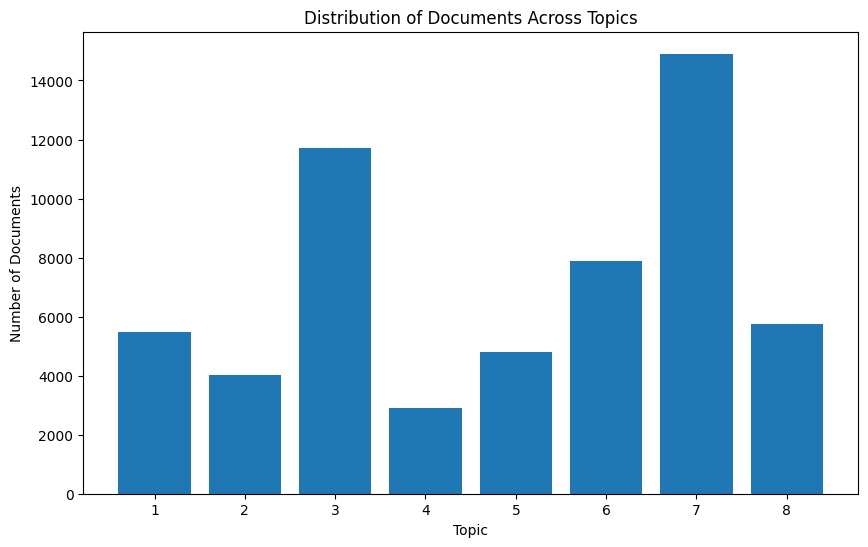

Wordcloud images saved in the 'wordcloud_images' directory.


In [ ]:
import os


output_dir = "wordcloud_images"
os.makedirs(output_dir, exist_ok=True)

# 定义需要过滤的词
filter_words =   {  "learn", "ad", "advertisement", "promo", "promotion", "click", "subscribe", "follow", "listen", 
    "watch", "read", "visit", "check", "download", "free", "offer", "choice", "exclusive", "bonus", 
    "sale", "deal", "get", "sign", "register", "join", "share", "tell", "buy", "support", 
    "sponsored", "new", "available", "limited", "order", "save", "only", "special", "win", "entry",
    "giveaway", "guide", "tips", "tricks", "hack", "easy", "fast", "quick", "simple", "step",
    "try", "start", "today", "now", "don't miss", "must", "need", "essential", "introducing", "featuring",
    "hosted", "podcast", "episode", "show", "series", "talk", "conversation",'link','adchoice','spotify'}


# 打印每个主题的前 10 个关键词，并过滤不需要的词
lda_keywords = []  # 用于存储每个主题的关键词
for idx, topic in enumerate(topic_word_distributions):
    top_keywords = [words[i] for i in topic.argsort()[:-50:-1] if words[i] not in filter_words]  # 过滤
    top_keywords = top_keywords[:10]  # 仅保留前10个
    lda_keywords.append(top_keywords)
    print(f"Topic {idx + 1}: {', '.join(top_keywords)}")

# 将文档分配到主题
doc_topic_distributions = lda.transform(X_bow)
df['Dominant_Topic'] = doc_topic_distributions.argmax(axis=1)

# 为每个 Podcast 分配对应的主题关键词
df['Topic_Keywords'] = df['Dominant_Topic'].apply(lambda topic: ', '.join(lda_keywords[topic]))

# 可视化主题分布
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_topics + 1), doc_topic_distributions.sum(axis=0))
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.title("Distribution of Documents Across Topics")
plt.savefig(os.path.join(output_dir, "topic_distribution.png"))  # 保存分布图为 PNG
plt.show()

# 为每个主题生成词云，并保存为 PNG 文件
def generate_wordcloud(topic_number):
    # 过滤主题中的不需要的词
    topic_words = {
        words[i]: topic_word_distributions[topic_number][i]
        for i in range(len(words))
        if words[i] not in filter_words
    }
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for Topic {topic_number + 1}')
    
    # 保存词云为 PNG 文件
   # output_path = os.path.join(output_dir, f"wordcloud_topic_{topic_number + 1}.png")
   # plt.savefig(output_path)
    plt.close()  # 关闭当前图表

# 生成所有主题的词云并保存
for topic_num in range(n_topics):
    generate_wordcloud(topic_num)

print(f"Wordcloud images saved in the '{output_dir}' directory.")


In [92]:
# -----------------------------
# Step 2: TF-IDF 特征
# -----------------------------
vectorizer_tfidf = TfidfVectorizer(max_features=500)
X_tfidf = vectorizer_tfidf.fit_transform(df['Tokenized_Description'])  # TF-IDF 矩阵


In [93]:
df.columns

Index(['Podcast_ID', 'Parent_Category', 'Episode_ID', 'Episode_Name',
       'Description', 'Release_Date', 'Is_Explicit', 'Language',
       'Available_Markets_Count', 'External_URL', 'Cleaned_Description',
       'Tokenized_Description', 'Dominant_Topic', 'Topic_Keywords'],
      dtype='object')

In [ ]:




df_output = pd.DataFrame()
df_output['Episode_ID'] = df['Episode_ID']  
df_output['TFIDF_Matrix'] = [','.join(map(str, row)) for row in X_tfidf.toarray()]
df_output['LDA_Distribution'] = [','.join(map(str, row)) for row in doc_topic_distributions]
df_output['Dominant_Topic'] = df['Dominant_Topic']
df_output['LDA_Keywords'] = df['Topic_Keywords']


df_output.to_csv("Metrics.csv", index=False, encoding="utf-8")
print("\u6570\u636e已\u4fdd\u5b58")


数据已保存


In [ ]:
import pickle


with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer_tfidf, f)



with open("lda_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


with open("lda_model.pkl", "wb") as f:
    pickle.dump(lda, f)


In [ ]:
import pandas as pd
import numpy as np
import ast
from sklearn.metrics.pairwise import cosine_similarity
import re
import spacy


nlp = spacy.load("en_core_web_sm")


def clean_and_tokenize(description):
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'http\S+|www\.\S+', '', text)  # 移除 URL
        text = re.sub(r'\b(visit|podcast|com|episode)\b', '', text)  # 移除特定单词
        text = re.sub(r'[\W_]+', ' ', text)  # 移除特殊字符
        text = re.sub(r'\s+', ' ', text).strip()  # 移除多余空格
        return text

    def tokenize(text):
        doc = nlp(text)
        return ' '.join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])

    return tokenize(clean_text(description))

# 相似度计算函数
def recommend_podcast(description, top_n=1):
    # 清洗和分词
    processed_desc = clean_and_tokenize(description)

    # TF-IDF 特征计算
    tfidf_vector = np.mean([tfidf_matrix[i] for i in range(len(tfidf_matrix))], axis=0)  # 假设需要自定义逻辑填充

    # LDA 分布计算
    lda_vector = np.mean([lda_distribution[i] for i in range(len(lda_distribution))], axis=0)  # 假设需要自定义逻辑填充

    # TF-IDF 相似度
    tfidf_similarities = cosine_similarity([tfidf_vector], tfidf_matrix).flatten()
    tfidf_most_similar_index = tfidf_similarities.argmax()

    # LDA 相似度
    lda_similarities = cosine_similarity([lda_vector], lda_distribution).flatten()
    lda_most_similar_index = lda_similarities.argmax()

    # 返回最相似的 Podcast（分别基于 TF-IDF 和 LDA）
    tfidf_recommendation = df.iloc[tfidf_most_similar_index]['Episode_ID']
    lda_recommendation = df.iloc[lda_most_similar_index]['Episode_ID']

    return {
        'TF-IDF Recommendation': tfidf_recommendation,
        'LDA Recommendation': lda_recommendation
    }

df = pd.read_csv("Results.csv")
tfidf_matrix = np.array([list(map(float, row.split(','))) for row in df['TFIDF_Matrix']])
lda_distribution = np.array([list(map(float, row.split(','))) for row in df['LDA_Distribution']])
# 示例输入
description_input = "This episode discusses the latest trends in technology and innovation."
recommendations = recommend_podcast(description_input)

print("TF-IDF Recommendation:")
print(recommendations['TF-IDF Recommendation'])
print("\nLDA Recommendation:")
print(recommendations['LDA Recommendation'])



In [46]:

df = pd.read_csv("Results.csv")
tfidf_matrix = np.array([list(map(float, row.split(','))) for row in df['TFIDF_Matrix']])
lda_distribution = np.array([list(map(float, row.split(','))) for row in df['LDA_Distribution']])
# 示例输入
description_input = "This episode discusses the latest trends in technology and innovation."
recommendations = recommend_podcast(description_input)

print("TF-IDF Recommendation:")
print(recommendations['TF-IDF Recommendation'])
print("\nLDA Recommendation:")
print(recommendations['LDA Recommendation'])


TF-IDF Recommendation:
6VcaMAg3NBeAPLlzYP3gv6

LDA Recommendation:
51G8A6uX4ACbLSHQYucGVt


In [61]:
import base64
import requests

CLIENT_ID = "cdbe1048ac9243c09caa8d7a369b929d"
CLIENT_SECRET = "d0d510e0bfc54ebfa2bd084dc0c59e26"
def get_spotify_token():
    url = "https://accounts.spotify.com/api/token"
    auth_header = f"{CLIENT_ID}:{CLIENT_SECRET}"
    headers = {
        "Authorization": f"Basic {base64.b64encode(auth_header.encode()).decode()}",
    }
    data = {"grant_type": "client_credentials"}
    response = requests.post(url, headers=headers, data=data)
    if response.status_code == 200:
        return response.json().get("access_token")
    else:
        return None
token = get_spotify_token()

In [64]:

def get_episode_details(episode_id, token):    #TODO
    url = f"https://api.spotify.com/v1/episodes/{episode_id}"
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        #st.error(f"Failed to fetch episode details. Status Code: {response.status_code}")
        return None
def find_similar_podcast_lda(lda_result, token):  #TODO
    """
    根据 LDA 推荐的 episode ID 获取相应的 episode 信息。

    :param lda_result: 推荐的 episode ID（字符串）
    :param token: Spotify API 的访问令牌
    :return: 包含推荐 episode 详细信息的字典
    """
    return get_episode_details(lda_result, token)    
# lda_result = recommendations['LDA Recommendation']    #TODO
lda_result = '51G8A6uX4ACbLSHQYucGVt'
lda_recommendation = find_similar_podcast_lda(lda_result, token)     

lda_recommendation

{'audio_preview_url': 'https://podz-content.spotifycdn.com/audio/clips/2oL2u0Z4x3JSTK7UH6Jhl4/clip_2000_53324.mp3',
 'description': '',
 'duration_ms': 55080,
 'explicit': False,
 'external_urls': {'spotify': 'https://open.spotify.com/episode/51G8A6uX4ACbLSHQYucGVt'},
 'href': 'https://api.spotify.com/v1/episodes/51G8A6uX4ACbLSHQYucGVt',
 'html_description': '',
 'id': '51G8A6uX4ACbLSHQYucGVt',
 'images': [{'height': 640,
   'url': 'https://i.scdn.co/image/ab6765630000ba8a45d057161fbcd791b9574cc4',
   'width': 640},
  {'height': 300,
   'url': 'https://i.scdn.co/image/ab67656300005f1f45d057161fbcd791b9574cc4',
   'width': 300},
  {'height': 64,
   'url': 'https://i.scdn.co/image/ab6765630000f68d45d057161fbcd791b9574cc4',
   'width': 64}],
 'is_externally_hosted': False,
 'is_playable': True,
 'language': 'en',
 'languages': ['en'],
 'name': 'Murder, Mystery & Makeup Podcast Trailer',
 'release_date': '2021-10-22',
 'release_date_precision': 'day',
 'show': {'available_markets': ['AD',


## Whole code